# TP2 - Clustering (PCA)

Ce notebook charge les données Hi-Seq, applique une réduction de dimension **PCA** à 100 composantes, puis applique K-Means, DBSCAN et Spectral Clustering.

Il utilise les fonctions de protocole de `tp2_utils.py` pour exécuter 10 fois les algorithmes stochastiques et génère des graphiques pour chaque résultat.

In [ ]:
# --- Imports et GESTION DES CHEMINS ---
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import warnings
import sys
from pathlib import Path

In [21]:

# Chemin actuel: notebooks/clustering -> Remonter de 2 niveaux
# --- Configuration des Chemins ---

PROJECT_ROOT = Path("../..").resolve()
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "HISEQ"
PROJECT_FCT = PROJECT_ROOT / "src"
sys.path.append(str(PROJECT_FCT))

print(f"Chemin du projet racine : {PROJECT_ROOT}")
print(f"Chargement des données depuis : {DATA_PROCESSED_PATH}")

Chemin du projet racine : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git
Chargement des données depuis : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git\data\HISEQ


In [22]:
# --- Imports depuis vos fichiers utilitaires ---
try:
    from utils import (
        evaluate_clustering,
        run_stochastic_protocol,
        print_protocol_summary,
        run_deterministic_protocol,
        plot_clusters 
    )
    from preprocess import (
        reduce_dimension_for_clustering,
        reduce_dimension_for_viz  
    )
except ImportError:
    print("ERREUR: Impossible d'importer les fonctions utilitaires depuis 'tp2_utils' ou 'tp2_preprocess'.")
    print("Vérifiez que la racine du projet est correcte et que les fichiers .py s'y trouvent.")

warnings.filterwarnings('ignore')

In [23]:
# --- Chargement des données ---
print("Chargement des données Hi-Seq normalisées...")
try:
    X_scaled = np.load(DATA_PROCESSED_PATH / 'hiseq_X_scaled.npy')
    y_hiseq = pd.read_csv(DATA_PROCESSED_PATH / 'hiseq_y_labels.csv', index_col=0).iloc[:, 0]
    print(f"Données chargées. Forme de X_scaled: {X_scaled.shape}")
except FileNotFoundError:
    print(f"ERREUR: Fichiers non trouvés dans {DATA_PROCESSED_PATH}")
    print("Veuillez d'abord exécuter le notebook 'PreparationData.ipynb'.")

Chargement des données Hi-Seq normalisées...
Données chargées. Forme de X_scaled: (801, 20531)


# 1. Réduction de Dimension (PCA)

In [45]:
# --- Constantes---
N_RUNS = 10
N_CLUSTERS = 5 # 5 classes dans HiSeq
N_COMPONENTS = 100
FIXED_SEED = 42

# --- PCA (100) ---
# X_scaled est un np.array, ce qui est compatible avec votre fonction
X_pca_100 = reduce_dimension_for_clustering(X_scaled, method='PCA', n_components=N_COMPONENTS)

# Créer un DataFrame pour les fonctions de visualisation (elles attendent un DF)
X_pca_100_df = pd.DataFrame(X_pca_100, index=y_hiseq.index)

Début de la réduction de dimension avec PCA à 100 composantes...
Réduction PCA terminée. Nouvelle forme : (801, 100)


# 2. Clustering sur Données Réduites (PCA)

============ 2.1 K-Means (PCA) - Protocole expérimental (10 exécutions) ============

In [26]:
# Définir la "fabrique" (factory) pour KMeans
kmeans_factory = lambda seed: KMeans(n_clusters=N_CLUSTERS, random_state=seed, n_init=10)

# Exécuter le protocole
df_kmeans_pca = run_stochastic_protocol(
    model_factory=kmeans_factory,
    data=X_pca_100,
    true_labels=y_hiseq,
    n_runs=N_RUNS,
    experiment_name="KMeans (PCA)",
    evaluate_clustering_func=evaluate_clustering
)

--- Protocole expérimental : KMeans (PCA) ---
  Exécution 1/10 (KMeans (PCA))...
  Exécution 2/10 (KMeans (PCA))...
  Exécution 3/10 (KMeans (PCA))...
  Exécution 4/10 (KMeans (PCA))...
  Exécution 5/10 (KMeans (PCA))...
  Exécution 6/10 (KMeans (PCA))...
  Exécution 7/10 (KMeans (PCA))...
  Exécution 8/10 (KMeans (PCA))...
  Exécution 9/10 (KMeans (PCA))...
  Exécution 10/10 (KMeans (PCA))...
Protocole KMeans (PCA) terminé.


In [27]:
# Afficher le résumé
results_kmeans_pca_mean = print_protocol_summary(df_kmeans_pca, "KMeans (PCA)")


--- Résultats KMeans (PCA) - (μ ± σ) sur 10 exécutions ---
Silhouette:        0.2049 ± 0.0004
Homogeneity:       0.8619 ± 0.0032
Completeness:      0.8479 ± 0.0031
V-Measure:         0.8548 ± 0.0032
ARI:               0.7963 ± 0.0067
Time (s):          0.1228 ± 0.0089
Memory (MB):       1.3731 ± 0.0987


In [37]:
print("Réduction des données PCA 100D à 2D pour visualisation (via UMAP)...")
# Note : X_pca_100_df a été créé dans la section 1
# On utilise la fonction de preprocess.py
X_pca_2d_viz = reduce_dimension_for_viz(X_pca_100_df, method='UMAP', n_components=2, random_state=FIXED_SEED)
print("Réduction pour visualisation terminée.")

Réduction des données PCA 100D à 2D pour visualisation (via UMAP)...
Réduction de dimension avec UMAP à 2 composantes...
Réduction pour visualisation terminée.


Génération du graphique pour K-Means (PCA)...
Réduction de dimension pour la visualisation avec umap...


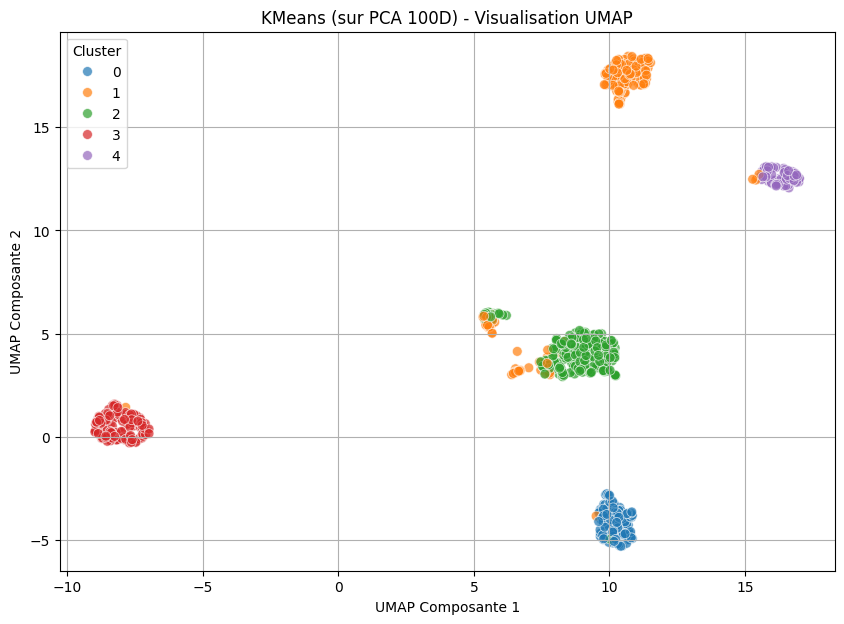

In [39]:
# --- Graphique K-Means (PCA) ---
print("Génération du graphique pour K-Means (PCA)...")
kmeans_pca_plot_model = KMeans(n_clusters=N_CLUSTERS, random_state=FIXED_SEED, n_init=10).fit(X_pca_100)
labels_kmeans_pca_plot = kmeans_pca_plot_model.labels_

# CORRECTION: Passage de X_pca_100_df (100D) et 'umap' (minuscule)
plot_clusters(X_pca_100_df, 
              labels_kmeans_pca_plot, 
              title='KMeans (sur PCA 100D) - Visualisation UMAP', 
              reducer_method='umap')

============ 2.2 DBSCAN (PCA) ============

In [28]:
#DBSCAN est déterministe. Une seule exécution suffit. 
print("Calcul de EPS pour DBSCAN (PCA)...")
neighbors_pca = NearestNeighbors(n_neighbors=5).fit(X_pca_100)
distances_pca, _ = neighbors_pca.kneighbors(X_pca_100)
distances_pca = np.sort(distances_pca, axis=0)[:, 4]
kneedle_pca = KneeLocator(range(len(distances_pca)), distances_pca, curve='convex', direction='increasing')
EPS_PCA_OPTIMAL = kneedle_pca.elbow_y if kneedle_pca.elbow_y else 126.0
print(f"EPS Optimal (PCA) trouvé: {EPS_PCA_OPTIMAL}")

Calcul de EPS pour DBSCAN (PCA)...
EPS Optimal (PCA) trouvé: 126.53904060021102


In [29]:
dbscan_pca_model = DBSCAN(eps=EPS_PCA_OPTIMAL, min_samples=5)

# Exécuter le protocole déterministe
results_dbscan_pca_series = run_deterministic_protocol(
    model=dbscan_pca_model,
    data=X_pca_100,
    true_labels=y_hiseq,
    experiment_name="DBSCAN (PCA)",
    evaluate_clustering_func=evaluate_clustering
)

--- Exécution : DBSCAN (PCA) ---
Exécution DBSCAN (PCA) terminée.

--- Résultats DBSCAN (PCA) - (1 exécution) ---
|                  |        0 |
|:-----------------|---------:|
| Silhouette       | nan      |
| Homogeneity      |   0.0000 |
| Completeness     |   1.0000 |
| V-Measure        |   0.0000 |
| ARI              |   0.0000 |
| Noise_Percentage |   5.3683 |
| Time (s)         |   0.0239 |
| Memory (MB)      |   2.0861 |


Génération du graphique pour DBSCAN (PCA)...
Réduction de dimension pour la visualisation avec umap...


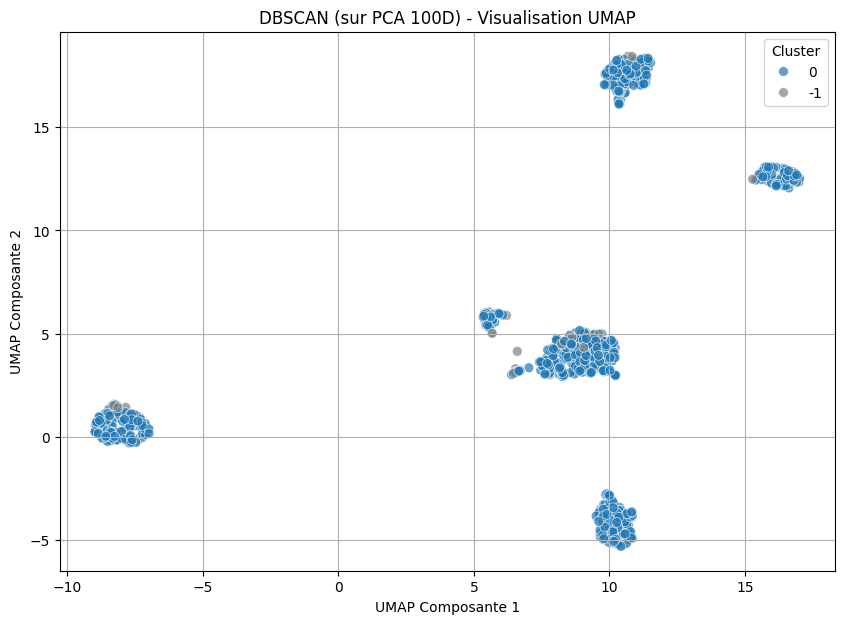

In [41]:
# --- Graphique DBSCAN (PCA) ---
print("Génération du graphique pour DBSCAN (PCA)...")
labels_dbscan_pca_plot = dbscan_pca_model.fit_predict(X_pca_100)

plot_clusters(X_pca_100_df, 
              labels_dbscan_pca_plot, 
              title='DBSCAN (sur PCA 100D) - Visualisation UMAP', 
              reducer_method='umap')

============ 2.3 Clustering Spectral (PCA) - Protocole expérimental (10 exécutions) ============

In [30]:
# Définir la "fabrique" pour Spectral Clustering
spectral_factory = lambda seed: SpectralClustering(n_clusters=N_CLUSTERS, assign_labels='kmeans', random_state=seed)

In [31]:
# Exécuter le protocole
df_spectral_pca = run_stochastic_protocol(
    model_factory=spectral_factory,
    data=X_pca_100,
    true_labels=y_hiseq,
    n_runs=N_RUNS,
    experiment_name="Spectral (PCA)",
    evaluate_clustering_func=evaluate_clustering
)

--- Protocole expérimental : Spectral (PCA) ---
  Exécution 1/10 (Spectral (PCA))...
  Exécution 2/10 (Spectral (PCA))...
  Exécution 3/10 (Spectral (PCA))...
  Exécution 4/10 (Spectral (PCA))...
  Exécution 5/10 (Spectral (PCA))...
  Exécution 6/10 (Spectral (PCA))...
  Exécution 7/10 (Spectral (PCA))...
  Exécution 8/10 (Spectral (PCA))...
  Exécution 9/10 (Spectral (PCA))...
  Exécution 10/10 (Spectral (PCA))...
Protocole Spectral (PCA) terminé.


In [32]:
# Afficher le résumé
results_spectral_pca_mean = print_protocol_summary(df_spectral_pca, "Spectral (PCA)")


--- Résultats Spectral (PCA) - (μ ± σ) sur 10 exécutions ---
Silhouette:        -0.0465 ± 0.0185
Homogeneity:       0.0069 ± 0.0019
Completeness:      0.0192 ± 0.0063
V-Measure:         0.0101 ± 0.0025
ARI:               0.0003 ± 0.0076
Time (s):          0.4431 ± 0.3589
Memory (MB):       20.9511 ± 0.0002


Génération du graphique pour Spectral (PCA)...
Réduction de dimension pour la visualisation avec umap...


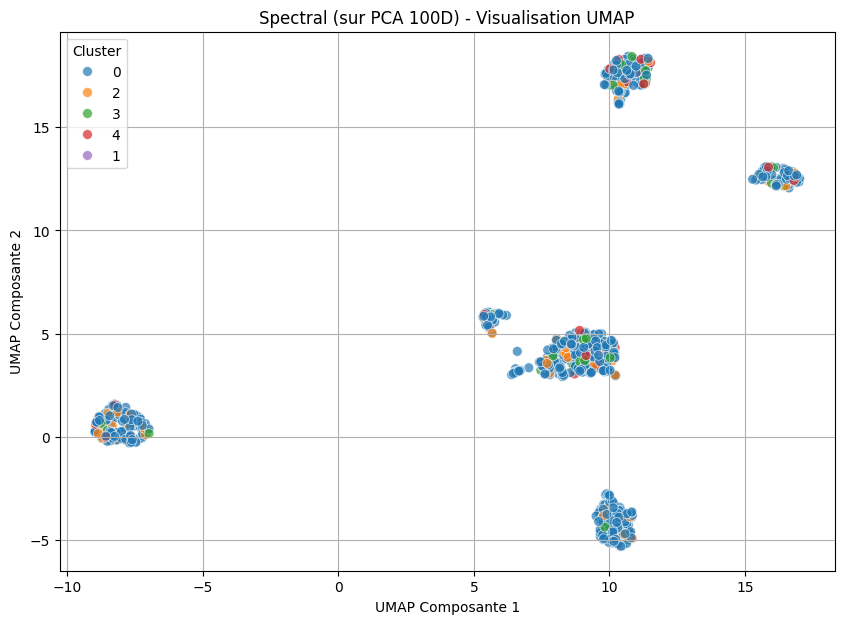

In [42]:
# --- Graphique Spectral (PCA) ---
print("Génération du graphique pour Spectral (PCA)...")
spectral_pca_plot_model = SpectralClustering(n_clusters=N_CLUSTERS, assign_labels='kmeans', random_state=FIXED_SEED).fit(X_pca_100)
labels_spectral_pca_plot = spectral_pca_plot_model.labels_

plot_clusters(X_pca_100_df, 
              labels_spectral_pca_plot, 
              title='Spectral (sur PCA 100D) - Visualisation UMAP', 
              reducer_method='umap')

# 4. Comparaison Finale (PCA)

In [43]:
# Combiner le tout
data_summary = {
    ('PCA', 'KMeans'): results_kmeans_pca_mean,
    ('PCA', 'DBSCAN'): results_dbscan_pca_series,
    ('PCA', 'Spectral'): results_spectral_pca_mean
}

In [44]:
df_final_results = pd.DataFrame(data_summary).T
df_final_results.index.names = ['Jeu', 'Algo']

print("\n--- Tableau Récapitulatif (Moyennes des 10 exécutions) ---")
# Assurer l'ordre des colonnes tel que défini dans vos utils
columns_order = ['ARI', 'V-Measure', 'Silhouette', 'Noise_Percentage', 'Time (s)', 'Memory (MB)', 'Homogeneity', 'Completeness']
final_columns = [col for col in columns_order if col in df_final_results.columns]
print(df_final_results[final_columns].to_markdown(floatfmt=".4f"))


--- Tableau Récapitulatif (Moyennes des 10 exécutions) ---
|                     |    ARI |   V-Measure |   Silhouette |   Noise_Percentage |   Time (s) |   Memory (MB) |   Homogeneity |   Completeness |
|:--------------------|-------:|------------:|-------------:|-------------------:|-----------:|--------------:|--------------:|---------------:|
| ('PCA', 'KMeans')   | 0.7963 |      0.8548 |       0.2049 |           nan      |     0.1228 |        1.3731 |        0.8619 |         0.8479 |
| ('PCA', 'DBSCAN')   | 0.0000 |      0.0000 |     nan      |             5.3683 |     0.0239 |        2.0861 |        0.0000 |         1.0000 |
| ('PCA', 'Spectral') | 0.0003 |      0.0101 |      -0.0465 |           nan      |     0.4431 |       20.9511 |        0.0069 |         0.0192 |
